In [2]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely as shp
import rasterio as rio 
from rasterio.plot import show
from skimage.filters import threshold_otsu
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Directories
data_dir = os.path.join(os.getcwd(),"data") # path to data-folder with aux data
plot_dir = os.path.join(os.getcwd(),"figures/plots")
proc_tiles_path = os.path.join(os.path.join(data_dir,"VN_processing_polygons")) # path to processing tiles
country_bounds_path = os.path.join(data_dir,"VN_country_bounds") # path to country bounds
osm_sl_path = os.path.join(os.path.join(data_dir,"VN_osm_coastline")) # path to reference shoreline
buffer_path = os.path.join(os.path.join(data_dir,"VN_buffer_5km"))

# Params
crs = "EPSG:3857"

# global Plotting params
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["font.size"] = 11
coastal_blue = "#074e67"
coastal_turquoise = "#05878a"
coastal_beige = "#b6af9d"
coastal_orange = "#ff8f7a"
coastal_grey = "#d7ccc8"

In [4]:
# read/ create aux data 
proc_tiles = gpd.read_file(proc_tiles_path).to_crs(crs)

### 1.| Number of (valid) Landsat aquistions in analysis

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


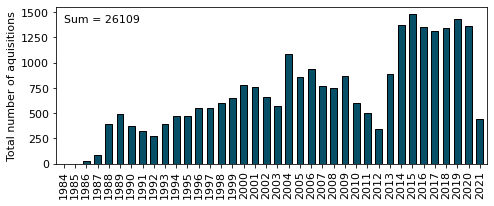

In [4]:
# Number of images used for processing coastlines of entire Vietnam from 1984-May 2
noa_list = []
for i in proc_tiles.id:
    tile_name = "P"+str(i).zfill(2) # name of processing tile
    folder_path = os.path.join(data_dir,tile_name) # path to mndwi rasters and meta
    meta_path = os.path.join(data_dir,tile_name,tile_name+".csv")
    meta = pd.read_csv(meta_path)
    meta = meta.drop(columns=['system:index','.geo'])
    meta = meta.transpose().rename(columns={0:"NOA"})
    meta['year'] = meta.index
    meta = meta.reset_index(drop=True)
    noa_list.append(meta)

noa_dict = {key:[] for key in range(1984,2022)}
for df in noa_list:
    years = list(df.year)
    for year in years:
        try:
            count = df.loc[np.where(np.array(years)==year)[0][0],"NOA"]
        except IndexError:
            count=0
        noa_dict[int(year)].append(count)

for year in noa_dict:
    noa_dict[year] = np.sum(noa_dict[year])

noa_df = pd.DataFrame(data=noa_dict.values(),index=noa_dict.keys())
noa_df = noa_df.rename(columns={0:"NOA"})

# plot
fig, ax = plt.subplots(figsize=(7, 3))
#fig, axes = plt.subplots(2, 3, figsize=(6, 5))
ax.bar(x=noa_df.index, height=noa_df["NOA"], color=coastal_blue, edgecolor="black", width=0.6)
ax.set_xticks(noa_df.index)
ax.margins(x=0.01)
ax.set_xticklabels(noa_df.index, rotation=90)
ax.set_ylabel("Total number of aquisitions")
ax.text(1984,1400,"Sum = "+str(int(np.sum(noa_df.NOA))))
fig.tight_layout()
fig.savefig(os.path.join(plot_dir,"Landsat_aquisitions"), dpi=150)
#plt.close(fig)

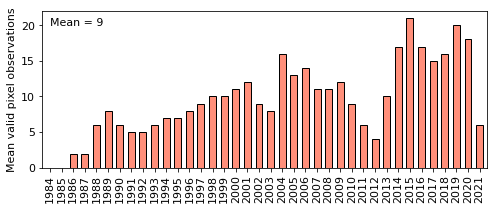

In [5]:
# Average number of pixel observations per year 
nvo_dict = {key:[] for key in range(1984,2022)}

for i in proc_tiles.id:
    tile_name = "P"+str(i).zfill(2) # name of processing tile
    folder_path = os.path.join(data_dir,tile_name) # path to mndwi rasters and meta
    files = glob.glob(os.path.join(folder_path,"*aq.tif"))
    for file in files:
        year = int(os.path.basename(file)[4:8])
        aq = int(os.path.basename(file)[9:11])
        nvo_dict[int(year)].append(aq)

for year in nvo_dict:
    if len(nvo_dict[year])==0: nvo_dict[year]=0
    nvo_dict[year] = np.mean(nvo_dict[year])

nvo_df = pd.DataFrame(data=nvo_dict.values(),index=nvo_dict.keys())
nvo_df = nvo_df.rename(columns={0:"NVO"})
nvo_df.NVO = nvo_df.NVO.round(0).astype(int)

# plot
fig, ax = plt.subplots(figsize=(7, 3))
ax.bar(x=nvo_df.index, height=nvo_df["NVO"], color=coastal_orange, edgecolor="black", width=0.6)
ax.set_xticks(nvo_df.index)
ax.margins(x=0.01)
ax.set_xticklabels(nvo_df.index, rotation=90)
ax.set_ylabel("Mean valid pixel observations")
ax.text(1984,20,"Mean = "+str(int(np.mean(nvo_df.NVO))))
fig.tight_layout()
fig.savefig(os.path.join(plot_dir,"Avg_pixel_observations"), dpi=150)
#plt.close(fig)

### 2.| Otsu thresholds

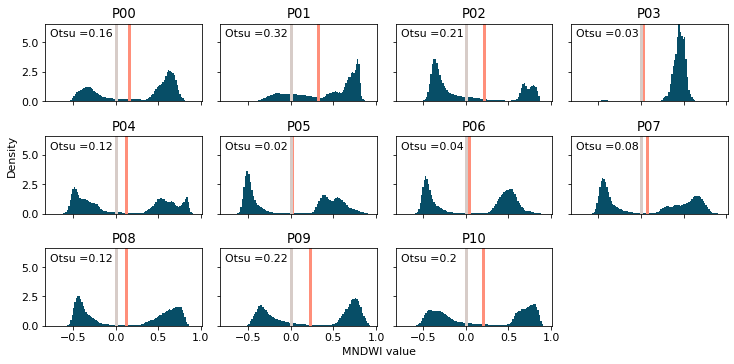

In [29]:
# Plot the Otsu thresholds of all processing tiles for 2015 (year with most valid observations)
from scipy import stats
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True,sharey=True, figsize=(10, 5))
fig.delaxes(axes[2,3])
for i, ax in zip(proc_tiles.id, axes.flatten()):
    tile_name = "P"+str(i).zfill(2) # name of processing tile
    folder_path = os.path.join(data_dir,tile_name) # path to mndwi rasters and meta
    raster_files = glob.glob(os.path.join(folder_path,"*2015*aq.tif"))
    for r in raster_files:
        year = os.path.basename(r)[4:8]
        with rio.open(r,"r") as raster:
            image = raster.read(1)
            if np.count_nonzero(image) > 0 and np.count_nonzero(~np.isnan(image)) > 0:
                thresh = threshold_otsu(image[~np.isnan(image)])
                ax.hist(image.ravel(),bins=100,color=coastal_blue,density=True)
                ax.axvline(thresh, color=coastal_orange,lw=3)
                ax.axvline(0,color=coastal_grey,lw=3)
                ax.margins(x=0.01,y=0.01)
                ax.annotate("Otsu ="+str(thresh.round(2)),xy=(0,1),xycoords="axes fraction",xytext=(5,-5), textcoords="offset points",ha="left",va="top")
                #if not (i % 4) == 0:
                    #ax.set_xticklabels([])
                    #ax.set_yticklabels([])
                    #ax.set_ylabel("Density")
                #ax.set_xlabel("MNDWI value")
                ax.set_title(tile_name)
fig.subplots_adjust(wspace=1,hspace=1)
fig.text(0.5,0,'MNDWI value',ha='center')
fig.text(-0.01,0.5,'Density',ha='center',rotation='vertical')
fig.tight_layout()
fig.savefig(os.path.join(plot_dir,"Otsus_"+year),bbox_inches='tight', dpi=400)

In [30]:
# plot the distribution of all otsu thresholds 
otsu_dict = {key:[] for key in range(0,10)}
for i in proc_tiles.id:
    tile_name = "P"+str(i).zfill(2) # name of processing tile
    folder_path = os.path.join(data_dir,tile_name) # path to mndwi rasters and meta
    sl_files = glob.glob(os.path.join(folder_path,tile_name+"_shorelines"))
    for file in sl_files:
        sl = gpd.read_file(file)
        otsu_dict[i] = list(sl.otsu_thres)

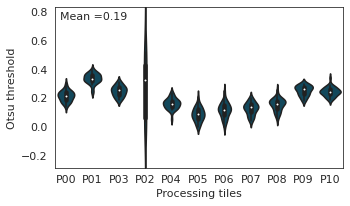

In [41]:
# plot
sns.set_style('white')

otsu_lists = list(otsu_dict.values())
#del otsu_lists[3]
otsus_flat = [y for x in otsu_lists for y in x]
otsus_flat = [float(item) for item in otsus_flat]
otsu_mean = np.mean(otsus_flat)

x_labels = ["P00","P01","P03","P02","P04","P05","P06","P07","P08","P09","P10"]

fig,ax = plt.subplots(figsize=(5, 3))
sns.violinplot(data=otsu_lists, color=coastal_blue)
ax.set_xticklabels(x_labels)
ax.margins(x=0.01,y=0)
ax.set_ylabel("Otsu threshold")
ax.set_xlabel("Processing tiles")
ax.annotate("Mean ="+str(otsu_mean.round(2)),xy=(0,1),xycoords="axes fraction",xytext=(5,-5), textcoords="offset points",ha="left",va="top")
fig.tight_layout()
fig.savefig(os.path.join(plot_dir,"Otsus_mean"), dpi=300)

### 3.| Coastline change statistics Vietnam

In [21]:
# get statistical information on coastline change in Vietnam 
VN_classifications = gpd.read_file(os.path.join(data_dir,"VN_all_classifications"))
VN_classifications = VN_classifications.dropna()

L1_values = pd.DataFrame(VN_classifications["class_L1"].value_counts(normalize=True))*100
L2_values = pd.DataFrame(VN_classifications["class_L2"].value_counts(normalize=True))*100
Erosion_values1 = pd.DataFrame(VN_classifications[VN_classifications.class_L1 == "Erosion"]["class_L2"].value_counts(normalize=True)*100)
Accretion_values = pd.DataFrame(VN_classifications[VN_classifications.class_L1 == "Accretion"]["class_L2"].value_counts(normalize=True)*100)

/home/ronja/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [31]:
# coastline change per province 
coastal_provinces_path = os.path.join(data_dir,"VN_coastal_provinces")
if not os.path.exists(coastal_provinces_path+"a"):
    VN_classifications = gpd.read_file(os.path.join(data_dir,"VN_all_classifications"))
    provinces = gpd.read_file(os.path.join(data_dir,"VN_provinces"))
    buffer = gpd.read_file(os.path.join(data_dir,"VN_buffer_5km"))
    provinces = provinces.to_crs(crs)

    # filter coastal provinces
    coastal_provinces = provinces.copy()
    for i, province in coastal_provinces.iterrows():
        if province.geometry.intersects(buffer.geometry[0]) == False:
            coastal_provinces = coastal_provinces.drop(i)

    # add proportion of transect with coastline change type to province dataframe
    # of Level1
    erosion_vals = []
    accretion_vals = []
    stable_vals = []
    for i, province in coastal_provinces.iterrows():
        p_class = gpd.clip(VN_classifications, province.geometry)
        L1_stats = p_class["class_L1"].value_counts(normalize=True)*100
        try:
            erosion_vals.append(L1_stats["Erosion"])
        except KeyError:
            erosion_vals.append(0)
        try:
            accretion_vals.append(L1_stats["Accretion"])
        except KeyError:
            accretion_vals.append(0)
        try:
            stable_vals.append(L1_stats["Stable"])
        except KeyError:
            stable_vals.append(0)
    coastal_provinces= coastal_provinces.reset_index(drop=True)
    coastal_provinces['Erosion'] = erosion_vals
    coastal_provinces['Accretion'] = accretion_vals 
    coastal_provinces['Stable'] = stable_vals 
    coastal_provinces.to_file(coastal_provinces_path,driver="GeoJSON")
else:
    print("Coastal provinces exist.")

/home/ronja/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
29
29


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


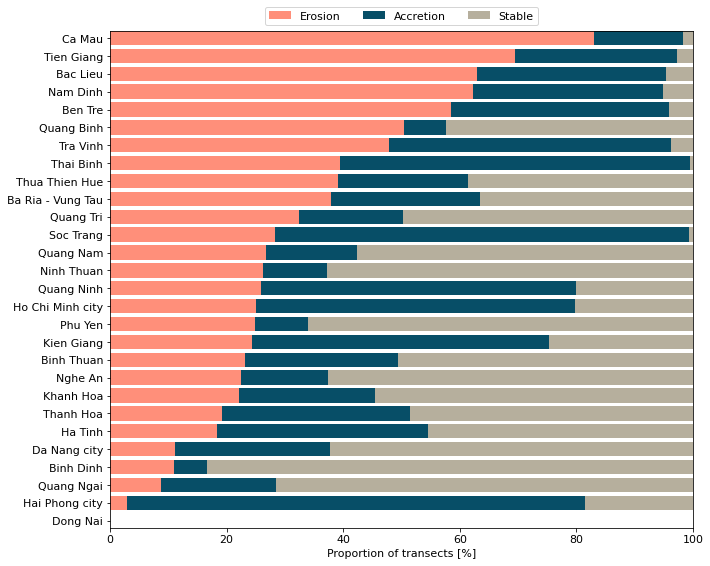

In [32]:
# plot cosatline change per province
coastal_provinces = gpd.read_file(os.path.join(data_dir,"VN_coastal_provinces"))
coastal_provinces = coastal_provinces.sort_values(by="Erosion",ascending=True).reset_index(drop=True)
coastal_provinces = coastal_provinces.drop(0)
fig, ax = plt.subplots(figsize=(10,8))
bars1 = coastal_provinces['Erosion']
bars2 = coastal_provinces['Accretion']
bars3 = coastal_provinces['Stable']
names = coastal_provinces["ADM1_EN"]
ax.barh(names,bars1,color=coastal_orange,label="Erosion")
ax.barh(names,bars2,left=bars1,color=coastal_blue,label="Accretion")
ax.barh(names,bars3,left=bars1+bars2,color=coastal_beige,label="Stable")
ax.set_xlabel("Proportion of transects [%]")
ax.margins(x=0,y=0)
ax.get_legend_handles_labels()
ax.legend(ncol=4,loc="lower center",bbox_to_anchor=[0.5,1])
fig.tight_layout()
fig.savefig(os.path.join(plot_dir,"Coastal_change_provinces"), bbox_inches='tight',dpi=300)

In [5]:
# coastline change hotspots 
coastal_provinces = gpd.read_file(os.path.join(data_dir,"VN_coastal_provinces"))
erosion_hotspots_original = gpd.read_file(os.path.join(data_dir,"VN_extreme_accretion_hotspots"))
erosion_hotspots = erosion_hotspots_original.dissolve("cluster_no", aggfunc="mean")
erosion_hotspots = erosion_hotspots.drop(columns=["Transect_id"])

number_hotspots = erosion_hotspots_original.cluster_no.unique()
sum_transects = []
for n in number_hotspots:
    cluster = erosion_hotspots_original[erosion_hotspots_original.cluster_no==n]
    sum_transects.append(len(cluster))
erosion_hotspots['Number_of_transects'] = sum_transects
erosion_hotspots['Length']= erosion_hotspots.Number_of_transects*200
erosion_hotspots = erosion_hotspots.set_crs(crs)

columns = list(coastal_provinces.columns)
columns.remove("geometry")
columns.remove("ADM1_EN")

coastal_provinces_red = coastal_provinces.drop(columns=columns)
join_df = gpd.tools.sjoin(erosion_hotspots,coastal_provinces_red,how="left")
join_df.to_file(os.path.join(data_dir,"VN_extreme_accretion_hotspots_grouped"),driver="GeoJSON")

erosion_hotspots_table = pd.DataFrame(join_df.drop(columns=["geometry","EPR","index_right"]))
aggregate_functions = {"LRR_slope":"mean","LRR_stderr":"mean","Number_of_transects":"sum","Length":"sum","ADM1_EN":"sum"}
erosion_hotspots_table = erosion_hotspots_table.groupby(erosion_hotspots_table.index).aggregate(aggregate_functions)
erosion_hotspots_table = erosion_hotspots_table.round(1).sort_values("Length",ascending=False).reset_index(drop=True)
erosion_hotspots_table.to_csv(os.path.join(plot_dir,"Accretion_hotspot_stats"))

/home/ronja/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [6]:
erosion_hotspots_table

,LRR_slope,LRR_stderr,Number_of_transects,Length,ADM1_EN
0,34.4,4.9,394,78800,Thai BinhHai Phong city
1,23.5,1.9,204,40800,Soc TrangTra Vinh
2,47.3,6.9,162,32400,Thanh HoaNinh Binh
3,22.6,3.3,160,32000,Soc Trang
4,39.0,3.3,113,22600,Ca Mau
5,8.6,2.5,86,17200,Bac Lieu
6,36.8,3.2,79,15800,Quang Ninh
7,11.4,1.6,73,14600,Kien Giang
8,14.8,1.0,71,14200,Kien Giang
9,25.3,2.5,63,12600,Quang Ninh
